In [1]:
# final.py — RiceAI agent with thread_id, chit-chat path, streaming (flush=True),
# and PERSISTENT STATE MEMORY in SQLite (langgraph.checkpoint.sqlite.SqliteSaver)

import os
import json
import sqlite3
from pathlib import Path
from typing import List, Dict, TypedDict, Any, Optional

from dotenv import load_dotenv
from qdrant_client import QdrantClient
from openai import OpenAI

from langchain.schema import Document
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.sqlite import SqliteSaver

from langchain_core.messages import (
    BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
)
from langchain.tools import tool
from pydantic import BaseModel, Field

# --- Your Neo4j KG tool ---
from kg_graph_tool import ask as kg_ask

# =========================
# Env & clients
# =========================
load_dotenv()
env_path = Path('.') / '.env'
if env_path.exists():
    with env_path.open() as f:
        for line in f:
            if '=' in line and not line.strip().startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ.setdefault(key, value)

QDRANT_URL = os.environ["QDRANT_URL"]
QDRANT_API_KEY = os.environ["QDRANT_API_KEY"]
COLLECTION_NAME = os.environ["QDRANT_COLLECTION_NAME"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

qdrant = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)
openai_client = OpenAI(api_key=OPENAI_API_KEY)

# =========================
# Helpers
# =========================
def get_query_embedding(text: str) -> List[float]:
    resp = openai_client.embeddings.create(model="text-embedding-3-small", input=text)
    return resp.data[0].embedding

def format_document_details(docs: List[Document]) -> str:
    blocks = []
    for doc in docs:
        meta = doc.metadata or {}
        blocks.append(
            f"- Title: {meta.get('title', 'No title')} (score: {meta.get('score', 0):.3f})\n"
            f"  URL: {meta.get('url', 'N/A')}\n"
            f"  Source: {meta.get('source', 'N/A')}\n"
            f"  Summary: {meta.get('summary', '')[:150]}...\n"
            f"  Preview: {doc.page_content[:150]}...\n"
        )
    return "\n".join(blocks) if blocks else "_No sources found._"

def build_memory_system_prompt(user_facts: Dict[str, str]) -> str:
    """Embed known user facts into a system message for personalization."""
    if not user_facts:
        return "Known user facts: (none). Do not invent facts. Be friendly and concise."
    parts = [f"- {k}: {v}" for k, v in user_facts.items() if str(v).strip()]
    return "Known user facts:\n" + "\n".join(parts)

# =========================
# Tools (Qdrant + Neo4j KG)
# =========================
@tool("qdrant_search", return_direct=False)
def qdrant_search(query: str, k: int = 5, threshold: float = 0.35) -> Dict[str, Any]:
    """
    Vector search over Qdrant.
    """
    print(f"[tool:qdrant_search] query='{query}', k={k}, threshold={threshold}")
    emb = get_query_embedding(query)
    results = qdrant.search(
        collection_name=COLLECTION_NAME,
        query_vector=emb,
        limit=k,
        with_payload=True,
        with_vectors=False,
        score_threshold=threshold
    )
    hits = []
    for r in results:
        payload = r.payload or {}
        hits.append({
            "score": r.score,
            "content": payload.get("content", ""),
            "title": payload.get("title", ""),
            "summary": payload.get("summary", ""),
            "url": payload.get("url", ""),
            "source": payload.get("source", ""),
            "chunk_id": payload.get("chunk_id", "")
        })
    print(f"[tool:qdrant_search] returned {len(hits)} hits")
    return {"hits": hits}

@tool("neo4j_kg_search", return_direct=False)
def neo4j_kg_search(query: str, limit: int = 5) -> Dict[str, Any]:
    """
    Neo4j KG search -> grounded answer + facts.
    """
    print(f"[tool:neo4j_kg_search] query='{query}', limit={limit}")
    from math import isfinite
    KG_MAX_DISTANCE = float(os.getenv("KG_MAX_DISTANCE", "0.85"))

    kg_res = kg_ask(query, chapter=None, top_k=limit, expand=min(4, max(1, limit)), per_node_limit=25)
    kg_hits = kg_res.get("hits", []) or []
    if not kg_hits:
        print("[tool:neo4j_kg_search] no KG hits")
        return {"hits": []}

    try:
        top_dist = float(kg_hits[0].get("score", 1.0))
    except Exception:
        top_dist = 1.0

    if not isfinite(top_dist) or top_dist > KG_MAX_DISTANCE:
        print(f"[tool:neo4j_kg_search] top distance {top_dist:.4f} > threshold {KG_MAX_DISTANCE:.4f} -> ignore KG")
        return {"hits": []}

    sim = max(0.0, min(1.0, 1.0 - top_dist))
    top = kg_hits[0]
    top_id   = top.get("id", "KG")
    top_name = top.get("name", top_id)
    answer   = (kg_res.get("answer") or "").strip()

    main_hit = {
        "score": sim,
        "content": answer,
        "title": f"Knowledge Graph: {top_name}",
        "summary": "Grounded answer from the Neo4j knowledge graph (with citations).",
        "url": "",
        "source": "neo4j-kg",
        "chunk_id": f"kg_{top_id}",
    }

    fact_hits = []
    for i, f in enumerate(kg_res.get("facts", [])[: max(0, limit - 1)]):
        fact_hits.append({
            "score": round(sim * 0.9, 6),
            "content": f.get("text", ""),
            "title": "KG Fact",
            "summary": "",
            "url": "",
            "source": "neo4j-kg",
            "chunk_id": f"kg_fact_{top_id}_{i}",
        })

    out = {"hits": [main_hit] + fact_hits}
    print(f"[tool:neo4j_kg_search] returning {len(out['hits'])} hits (sim={sim:.4f}, dist={top_dist:.4f})")
    return out

TOOLS = [qdrant_search, neo4j_kg_search]

# --- 1) Utility: remove ToolMessages from a message list
def _clean_msgs_for_llm(msgs: List[BaseMessage]) -> List[BaseMessage]:
    return [m for m in msgs if not isinstance(m, ToolMessage)]

# (optional) If you prefer to keep a hint that tools ran:
def _summarize_msgs_for_prompt(msgs: List[BaseMessage]) -> str:
    lines = []
    for m in msgs[-8:]:  # last few only
        if isinstance(m, HumanMessage):
            lines.append(f"User: {m.content}")
        elif isinstance(m, AIMessage):
            lines.append(f"Assistant: {m.content}")
        # skip ToolMessage entirely (or add a one‑liner if you really want)
    return "\n".join(lines)

# =========================
# Explicit, example-rich prompts
# =========================

# Rewriter: produce a single, crisp retrieval-friendly question
rewriter_system = SystemMessage(content=(
    "Rewrite the user's latest message as a single, standalone query optimized for retrieval.\n"
            "Preserve key entities (e.g., Vietnam, Mekong Delta), inputs (crop stage/soil), and regulatory intent.\n"
            "Prefer adding clarifying terms like 'rice', 'agriculture', 'IPM', 'MRL', 'ban list', 'regulation' when implied.\n"
            "Examples:\n"
            " - 'hey can you help me with AWD for heavy clay soils?' -> 'Best AWD practices for heavy clay rice soils (Vietnam context).'\n"
            " - 'how much urea should I use on 1 ha?' -> 'Recommended urea rates per hectare in irrigated rice (Vietnam).'\n"
            " - 'tell me about insecticides and pesticides banned in vietnamese' -> "
            "'Pesticides/insecticides banned or restricted in Vietnam rice production (official ban list, MRLs, current rules).'\n"
            " - 'tell me pesticides for farming banned in vietnam' -> "
            "'Pesticides banned/restricted for crop farming in Vietnam, with rice-specific notes and safer alternatives (IPM).'\n"

))

# Planner guidance (tool decision)
planner_system = SystemMessage(content=(
    "You are a retrieval planner. Decide which tools to call to fetch context.\n"
    "- Use qdrant_search for semantic docs.\n"
    "- If the question mentions practices/entities/relationships (AWD, straw, IPM, mechanization) "
    "  ALSO call neo4j_kg_search.\n"
    "- When unsure: call BOTH (qdrant first). Keep calls minimal but sufficient."
))

# RAG answer template (memory-aware)
rag_template = """
You are RiceAI Expert, a trusted agronomist trained on sustainable, high-yield rice practices.

{memory_system}

INSTRUCTIONS:
- Answer using the retrieved context. If conflicts, state the most reliable practice and note uncertainty.
- Be explicit, practical, and step-by-step.
- Include actionable numbers (rates, timings) when available.

Chat history (may help for continuity): {history}

Retrieved context:
{context}

User question: {question}
"""
rag_prompt = ChatPromptTemplate.from_template(rag_template)

# Chit-chat base rules (we inject memory later)
chitchat_base = (
    "You are a warm, concise assistant. Keep replies brief and friendly. "
    "Use known user facts naturally. If you don't know a fact, don't guess—invite the user to share it."
)

# =========================
# LLMs
# =========================
rag_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY)
planner_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).bind_tools(TOOLS)
chitchat_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3, openai_api_key=OPENAI_API_KEY)
rewriter_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY)

rag_chain = rag_prompt | rag_llm

# =========================
# State + Schemas
# =========================
class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    label: str                    # 'rice', 'chitchat', 'offtopic'
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage
    user_facts: Dict[str, str]    # persistent per-thread memory

class GradeLabel(BaseModel):
    label: str = Field(..., description="One of: rice, chitchat, offtopic")

class GradeDocument(BaseModel):
    score: str = Field(..., description="Respond with 'Yes' or 'No'")

# =========================
# Nodes
# =========================
def question_rewriter(state: AgentState) -> AgentState:
    print("=== Entering question_rewriter ===")
    state.setdefault("user_facts", {})
    state.setdefault("messages", [])
    state.setdefault("rephrase_count", 0)

    # DO NOT wipe label/proceed/docs here; other nodes manage them.
    # Just ensure the latest question is in history
    if state.get("question") and state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    # Base text to rewrite
    q = state["question"].content if state.get("question") else ""
    state["rephrased_question"] = q  # safe default

    # If there’s any prior history, include it — but strip ToolMessages
    if len(state["messages"]) > 1:
        conversation = _clean_msgs_for_llm(state["messages"][:-1])
    else:
        conversation = []

    # Domain-aware rewriter: preserve locales, regulatory intent, rice/ag terms
    rewriter_system = SystemMessage(content=(
        "Rewrite the user's latest message as a single, standalone query optimized for retrieval. "
        "Preserve key entities (e.g., Vietnam, Mekong Delta), crop/soil/stage details, and any regulatory intent. "
        "When implied, add clarifiers like 'rice', 'agriculture', 'IPM', 'MRL', 'ban list', 'regulation'. "
        "Return ONLY the refined query."
        "\nExamples:\n"
        " - 'hey can you help me with AWD for heavy clay soils?' -> "
        "'Best AWD practices for heavy clay rice soils (Vietnam context).'\n"
        " - 'how much urea should I use on 1 ha?' -> "
        "'Recommended urea rates per hectare in irrigated rice (Vietnam).'\n"
        " - 'tell me about insecticides and pesticides banned in vietnamese' -> "
        "'Pesticides/insecticides banned or restricted in Vietnam rice production (official ban list, MRLs, current rules).'\n"
        " - 'tell me pesticides for farming banned in vietnam' -> "
        "'Pesticides banned/restricted for crop farming in Vietnam, with rice-specific notes and safer IPM alternatives.'\n"
    ))

    human = HumanMessage(content=q or "N/A")
    msgs: List[BaseMessage] = [rewriter_system] + conversation + [human]

    try:
        resp = rewriter_llm.invoke(msgs)
        refined = (resp.content or "").strip()
        if refined:
            state["rephrased_question"] = refined
            print(f"[question_rewriter] Rephrased: {refined}")
        else:
            print("[question_rewriter] Empty rewrite; using original.")
    except Exception as e:
        print(f"[question_rewriter] Rewrite failed: {e}; using original.")

    return state


def fact_extractor(state: AgentState) -> AgentState:
    """
    Extract simple user facts from the latest human message and update state['user_facts'].
    Strong prompt + regex fallback for location/name.
    """
    print("=== Entering fact_extractor ===")
    state.setdefault("user_facts", {})
    latest = state["question"].content

    system = SystemMessage(content=(
        "From the user's last message, extract any stable personal facts as a compact JSON object.\n"
        "Allowed keys: name, location, city, country, residence, profession, college, farm_size, rice_variety, "
        "role, company, preferences, email, phone, other.\n"
        "Return ONLY JSON. If none, return {}.\n"
        "Examples:\n"
        "  'I am Ravi' -> {\"name\":\"Ravi\"}\n"
        "  'I'm from Lagos' -> {\"location\":\"Lagos\"}\n"
        "  'I live in Ireland' -> {\"location\":\"Ireland\"}\n"
        "  'I grow NERICA 1' -> {\"rice_variety\":\"NERICA 1\"}\n"
        "  '3 ha farm' -> {\"farm_size\":\"3 ha\"}"
    ))
    human = HumanMessage(content=latest)

    data: Dict[str, str] = {}
    try:
        resp = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).invoke([system, human])
        txt = (resp.content or "").strip()
        if txt.startswith("{"):
            data = json.loads(txt)
    except Exception:
        data = {}

    # Fallback regex heuristics (location & name)
    import re
    if not data.get("location"):
        m = re.search(r"\b(?:i\s*(?:am|'m)?\s*(?:from|in)|i\s*live\s*in|living\s*in|reside\s*in)\s+([A-Za-z .,'-]+)", latest, re.I)
        if m:
            loc = m.group(1).strip(" .,'-")
            if loc:
                data["location"] = loc
    if not data.get("name"):
        m = re.search(r"\b(?:i\s*am|i'm)\s+([A-Za-z][A-Za-z .'-]{1,40})$", latest.strip(), re.I)
        if m:
            data["name"] = m.group(1).strip(" .,'-")

    if isinstance(data, dict):
        cleaned = {k: str(v).strip() for k, v in data.items() if str(v).strip()}
        if cleaned:
            state["user_facts"].update(cleaned)
            print(f"[fact_extractor] Updated user_facts: {state['user_facts']}")
    return state

def question_classifier(state: AgentState) -> AgentState:
    print("=== Entering question_classifier ===")
    system_message = SystemMessage(
        content=(
            "Classify the user's request into one label. Default to 'rice' if it is even loosely "
            "about crops, farming, land, water, pests, pesticides/insecticides/herbicides/fungicides, "
            "fertilizers (organic or inorganic), diseases, varieties, harvest, storage, milling, markets, "
            "or anything that could be answered by an agriculture/rice knowledge base.\n"
            "- 'rice' = any agriculture topic (not only strict rice). Be **inclusive**.\n"
            "- 'chitchat' = greetings/small talk/identity/thanks/jokes.\n"
            "- 'offtopic' = truly unrelated (e.g., movies, politics, crypto)."
        )
    )
    human_message = HumanMessage(content=f"User message: {state['rephrased_question']}\nLabel:")
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    grader_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).with_structured_output(GradeLabel)
    result = (grade_prompt | grader_llm).invoke({})
    state["label"] = result.label.strip().lower()
    print(f"[question_classifier] label = {state['label']}")
    return state

def retrieve_planner(state: AgentState) -> AgentState:
    print("=== Entering retrieve_planner ===")
    question = state["rephrased_question"]
    messages = [planner_system, HumanMessage(content=f"Plan retrieval for: {question}")]
    ai = planner_llm.invoke(messages)
    state.setdefault("messages", [])
    state["messages"].append(ai)
    print(f"[retrieve_planner] Tool calls planned: {getattr(ai, 'tool_calls', [])}")
    return state

tool_node = ToolNode(TOOLS)

def collect_tool_results(state: AgentState) -> AgentState:
    print("=== Entering collect_tool_results ===")
    tool_msgs = [m for m in state["messages"] if isinstance(m, ToolMessage)]
    hits_all: List[Dict[str, Any]] = []
    for tm in tool_msgs:
        payload: Dict[str, Any] = {}
        if isinstance(tm.content, str):
            try:
                payload = json.loads(tm.content)
            except Exception:
                payload = {}
        elif isinstance(tm.content, dict):
            payload = tm.content
        hits_all.extend(payload.get("hits", []))

    # Dedupe by chunk_id, keep best score
    best_by_chunk: Dict[str, Dict[str, Any]] = {}
    for h in hits_all:
        cid = h.get("chunk_id") or f"row_{len(best_by_chunk)}"
        if cid not in best_by_chunk or h.get("score", 0) > best_by_chunk[cid].get("score", 0):
            best_by_chunk[cid] = h
    ordered = sorted(best_by_chunk.values(), key=lambda x: x.get("score", 0), reverse=True)
    docs: List[Document] = []
    for h in ordered:
        docs.append(Document(
            page_content=h.get("content", ""),
            metadata={
                "score": h.get("score", 0.0),
                "title": h.get("title", ""),
                "summary": h.get("summary", ""),
                "url": h.get("url", ""),
                "source": h.get("source", ""),
                "chunk_id": h.get("chunk_id", ""),
            }
        ))
    state["documents"] = docs
    print(f"[collect_tool_results] Collected {len(docs)} documents")
    return state

def retrieval_grader(state: AgentState) -> AgentState:
    print("=== Entering retrieval_grader ===")
    relevant_docs: List[Document] = []
    for doc in state["documents"]:
        system_message = SystemMessage(content="You are a grader assessing relevance. Reply 'Yes' or 'No'.")
        human_message = HumanMessage(content=f"User question: {state['rephrased_question']}\n\nRetrieved:\n{doc.page_content}")
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).with_structured_output(GradeDocument)
        result = (grade_prompt | grader_llm).invoke({})
        print(f"[retrieval_grader] Doc preview: {doc.page_content[:30]!r} -> {result.score.strip()}")
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"[retrieval_grader] proceed_to_generate = {state['proceed_to_generate']} (kept {len(relevant_docs)})")
    return state

def proceed_router(state: AgentState) -> str:
    print("=== Entering proceed_router ===")
    if state.get("proceed_to_generate", False):
        print("[proceed_router] -> generate_answer")
        return "generate_answer"
    elif state.get("rephrase_count", 0) >= 2:
        print("[proceed_router] -> cannot_answer")
        return "cannot_answer"
    else:
        print("[proceed_router] -> refine_question")
        return "refine_question"

def refine_question(state: AgentState) -> AgentState:
    print("=== Entering refine_question ===")
    if state.get("rephrase_count", 0) >= 2:
        return state

    q = state["rephrased_question"]

    rewriter_system = SystemMessage(
        content=(
            "Rewrite the user's latest message as a single, standalone query optimized for retrieval.\n"
            "Preserve key entities (e.g., Vietnam, Mekong Delta), inputs (crop stage/soil), and regulatory intent.\n"
            "Prefer adding clarifying terms like 'rice', 'agriculture', 'IPM', 'MRL', 'ban list', 'regulation' when implied.\n"
            "Examples:\n"
            " - 'hey can you help me with AWD for heavy clay soils?' -> 'Best AWD practices for heavy clay rice soils (Vietnam context).'\n"
            " - 'how much urea should I use on 1 ha?' -> 'Recommended urea rates per hectare in irrigated rice (Vietnam).'\n"
            " - 'tell me about insecticides and pesticides banned in vietnamese' -> "
            "'Pesticides/insecticides banned or restricted in Vietnam rice production (official ban list, MRLs, current rules).'\n"
            " - 'tell me pesticides for farming banned in vietnam' -> "
            "'Pesticides banned/restricted for crop farming in Vietnam, with rice-specific notes and safer alternatives (IPM).'\n"
        )
    )

    human_message = HumanMessage(
        content=f"Original question: {q}\n\nProvide a refined standalone question only."
    )

    refine_prompt = ChatPromptTemplate.from_messages([rewriter_system, human_message])
    resp = ChatOpenAI(
        model="gpt-4o-mini",
        temperature=0,
        openai_api_key=OPENAI_API_KEY
    ).invoke(refine_prompt.format())

    refined = resp.content.strip()
    print(f"[refine_question] Refined: {refined}")

    state["rephrased_question"] = refined
    state["rephrase_count"] = state.get("rephrase_count", 0) + 1
    return state


def generate_answer(state: AgentState) -> AgentState:
    print("=== Entering generate_answer ===")
    history = state["messages"]
    documents = state["documents"]
    rq = state["rephrased_question"]
    context_str = "\n\n".join(doc.page_content for doc in documents)
    memory_system = build_memory_system_prompt(state.get("user_facts", {}))

    response = rag_chain.invoke({
        "history": history,
        "context": context_str,
        "question": rq,
        "memory_system": memory_system
    })
    generation = response.content.strip()

    # Small personalization footer if we know their name
    name = state.get("user_facts", {}).get("name")
    if name:
        generation = f"{generation}\n\n— Hope that helps, {name}!"

    sources_md = format_document_details(documents)
    final_text = f"{generation}\n\n---\n### Sources used\n{sources_md}"

    state["messages"].append(AIMessage(content=final_text))
    print("[generate_answer] Done. (Answer + sources appended to state['messages'])")
    return state

def chit_chat(state: AgentState) -> AgentState:
    print("=== Entering chit_chat ===")
    facts = state.get("user_facts", {})
    q = state["question"].content.strip()
    qlow = q.lower()

    # Deterministic memory answers for common identity Qs
    if any(kw in qlow for kw in ["what's my name", "whats my name", "my name", "who am i"]):
        name = facts.get("name")
        text = f"You told me your name is **{name}**. 🙂" if name else \
               "I don't have your name saved yet—tell me what you'd like me to call you and I’ll remember it."
    elif any(kw in qlow for kw in ["where do i live", "my current place of residence", "where am i from", "where i live"]):
        loc = facts.get("location") or facts.get("city") or facts.get("country") or facts.get("residence")
        text = f"You told me you live in **{loc}**." if loc else \
               "I don't have your location yet—where do you live?"
    elif "tell me about myself" in qlow or "what do you know about me" in qlow:
        bits = []
        if facts.get("name"): bits.append(f"your name is **{facts['name']}**")
        if facts.get("location"): bits.append(f"you live in **{facts['location']}**")
        if facts.get("rice_variety"): bits.append(f"you grow **{facts['rice_variety']}**")
        if facts.get("farm_size"): bits.append(f"your farm size is **{facts['farm_size']}**")
        if facts.get("profession"): bits.append(f"you are a **{facts['profession']}**")
        if facts.get("college"): bits.append(f"you studied at **{facts['college']}**")
        text = "So far, I know " + ", ".join(bits) + "." if bits else \
               "I only know a little about you. Share more, and I’ll remember it."
    else:
        # Memory-aware chit-chat fallback
        mem_line = build_memory_system_prompt(facts)
        system = SystemMessage(content=f"{chitchat_base}\n\n{mem_line}\n"
                                       "When it's natural, weave one relevant fact into the reply.")
        human = HumanMessage(content=q)
        resp = chitchat_llm.invoke([system, human])
        text = resp.content.strip()

    state.setdefault("messages", [])
    state["messages"].append(AIMessage(content=text))
    return state

def cannot_answer(state: AgentState) -> AgentState:
    print("=== Entering cannot_answer ===")
    state.setdefault("messages", [])
    state["messages"].append(AIMessage(content="I'm sorry, but I couldn't find enough information to answer that clearly."))
    return state

def off_topic_response(state: AgentState) -> AgentState:
    print("=== Entering off_topic_response ===")
    state.setdefault("messages", [])
    state["messages"].append(
        AIMessage(content="I'm focused on rice farming topics. Ask me about cultivation, water, fertilizer, IPM, AWD, harvest, markets, etc.")
    )
    return state

# =========================
# Graph
# =========================
workflow = StateGraph(AgentState)

# Nodes
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("fact_extractor", fact_extractor)          # run extractor every turn
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("retrieve_planner", retrieve_planner)
workflow.add_node("tools", tool_node)
workflow.add_node("collect_tool_results", collect_tool_results)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("chit_chat", chit_chat)

# Edges
workflow.add_edge("question_rewriter", "fact_extractor")
workflow.add_edge("fact_extractor", "question_classifier")

workflow.add_conditional_edges(
    "question_classifier",
    lambda s: "retrieve_planner" if s.get("label") == "rice" else ("chit_chat" if s.get("label") == "chitchat" else "off_topic_response"),
    {
        "retrieve_planner": "retrieve_planner",
        "chit_chat": "chit_chat",
        "off_topic_response": "off_topic_response",
    },
)

workflow.add_edge("retrieve_planner", "tools")
workflow.add_edge("tools", "collect_tool_results")
workflow.add_edge("collect_tool_results", "retrieval_grader")

workflow.add_conditional_edges(
    "retrieval_grader",
    lambda s: "generate_answer" if s.get("proceed_to_generate") else ("cannot_answer" if s.get("rephrase_count", 0) >= 2 else "refine_question"),
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer",
    },
)
workflow.add_edge("refine_question", "retrieve_planner")

# End nodes
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)
workflow.add_edge("chit_chat", END)

# =========================
# Compile with SQLite checkpointer (per thread)
# =========================
workflow.set_entry_point("question_rewriter")

Path("data").mkdir(exist_ok=True)
conn = sqlite3.connect("data/agent_state.sqlite", check_same_thread=False)
checkpointer = SqliteSaver(conn)

graph = workflow.compile(checkpointer=checkpointer)

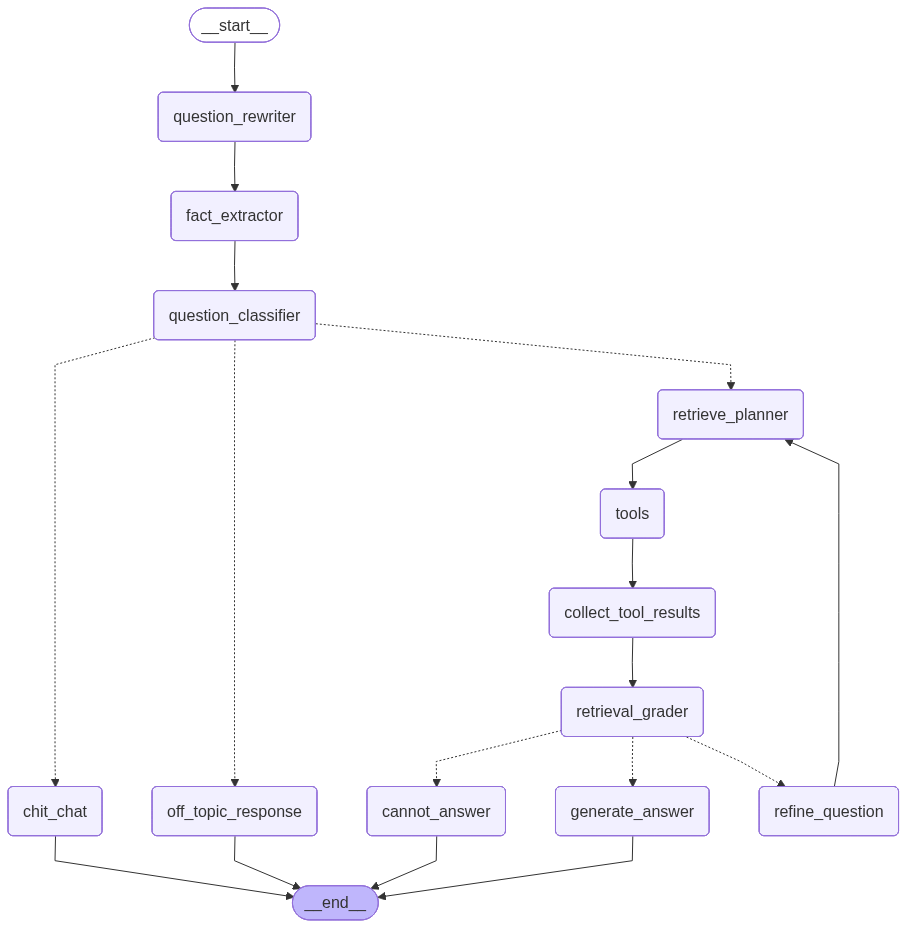

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	question_rewriter(question_rewriter)
	fact_extractor(fact_extractor)
	question_classifier(question_classifier)
	retrieve_planner(retrieve_planner)
	tools(tools)
	collect_tool_results(collect_tool_results)
	retrieval_grader(retrieval_grader)
	generate_answer(generate_answer)
	refine_question(refine_question)
	cannot_answer(cannot_answer)
	off_topic_response(off_topic_response)
	chit_chat(chit_chat)
	__end__([<p>__end__</p>]):::last
	__start__ --> question_rewriter;
	collect_tool_results --> retrieval_grader;
	fact_extractor --> question_classifier;
	question_classifier -.-> chit_chat;
	question_classifier -.-> off_topic_response;
	question_classifier -.-> retrieve_planner;
	question_rewriter --> fact_extractor;
	refine_question --> retrieve_planner;
	retrieval_grader -.-> cannot_answer;
	retrieval_grader -.-> generate_answer;
	retrieval_grader -.-> refine_question;
	retrieve_planner --> tool

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
display(Image(png_bytes))

print(graph.get_graph().draw_mermaid())  # Mermaid source
